In [8]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')
     
import torch
import numpy as np

def validate_model(model, val_dataset, tolerance=0.1, device='cuda'):
    model.eval()
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    val_losses = []
    val_accuracies = []
    reconstruction_errors = []

    with torch.no_grad():
        for seq_true in val_dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            # Compute loss (reconstruction error)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

            # Compute accuracy
            abs_error = torch.abs(seq_true - seq_pred)
            correct = (abs_error < tolerance).float()
            accuracy = correct.mean().item() * 100
            val_accuracies.append(accuracy)

            # Store per-sample reconstruction errors (mean over sequence)
            mean_error = abs_error.mean(dim=-1).cpu().numpy()  # Mean over sequence length
            reconstruction_errors.extend(mean_error)

    avg_val_loss = np.mean(val_losses)
    avg_val_acc = np.mean(val_accuracies)
    reconstruction_errors = np.array(reconstruction_errors)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.2f}%")
    print(f"Mean Reconstruction Error: {np.mean(reconstruction_errors):.4f}")
    print(f"Std Reconstruction Error: {np.std(reconstruction_errors):.4f}")

    return reconstruction_errors
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[0].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()

In [18]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
     
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape
# Splitting the Dataset

# Initial Train-Validation Split:
# The dataset 'normal_df' is divided into training and validation sets.
# 15% of the data is allocated to the validation set.

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)

# Further Splitting for Validation and Test:
# The validation set obtained in the previous step is further split into validation and test sets.
# 33% of the validation set is allocated to the test set.
# The same 'random_state=42' is used for consistency in randomization.

val_df, test_df = train_test_split(
  val_df,
  test_size=0.30,
  random_state=42
)
# Function to Create a Dataset
def create_dataset(df):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features
     

# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)
     


In [19]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))


class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)


class Autoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)

In [20]:
class GRUEncoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(GRUEncoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.gru1 = nn.GRU(input_size=n_features, hidden_size=self.hidden_dim, batch_first=True)
        self.gru2 = nn.GRU(input_size=self.hidden_dim, hidden_size=embedding_dim, batch_first=True)

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, _ = self.gru1(x)
        x, hidden_n = self.gru2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

class GRUDecoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(GRUDecoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.gru1 = nn.GRU(input_size=input_dim, hidden_size=input_dim, batch_first=True)
        self.gru2 = nn.GRU(input_size=input_dim, hidden_size=self.hidden_dim, batch_first=True)

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

class GRUAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(GRUAutoencoder, self).__init__()
        self.encoder = GRUEncoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = GRUDecoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model_lstm = Autoencoder(seq_len, n_features, 128).to(device)
model_gru = GRUAutoencoder(seq_len, n_features, 128).to(device)

# Load trained weights
model_lstm.load_state_dict(torch.load('/kaggle/input/lstm_autoencoder/pytorch/default/1/lstm_auto_encoder.pth', map_location=device))
model_gru.load_state_dict(torch.load('/kaggle/input/gru_autoencoder/pytorch/default/1/gru_auto_encoder.pth', map_location=device))

model_lstm.eval()
model_gru.eval()


GRUAutoencoder(
  (encoder): GRUEncoder(
    (gru1): GRU(1, 256, batch_first=True)
    (gru2): GRU(256, 128, batch_first=True)
  )
  (decoder): GRUDecoder(
    (gru1): GRU(128, 128, batch_first=True)
    (gru2): GRU(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [24]:
def evaluate_model(model, dataset):
    model.eval()
    errors = []

    with torch.no_grad():
        for seq in dataset:
            seq = seq.to(device)
            reconstructed = model(seq)
            loss = torch.mean((reconstructed - seq.squeeze(1))**2).item()
            errors.append(loss)

    return np.array(errors)


In [25]:
lstm_errors_normal = evaluate_model(model_lstm, test_normal_dataset)
lstm_errors_anomaly = evaluate_model(model_lstm, test_anomaly_dataset)

gru_errors_normal = evaluate_model(model_gru, test_normal_dataset)
gru_errors_anomaly = evaluate_model(model_gru, test_anomaly_dataset)


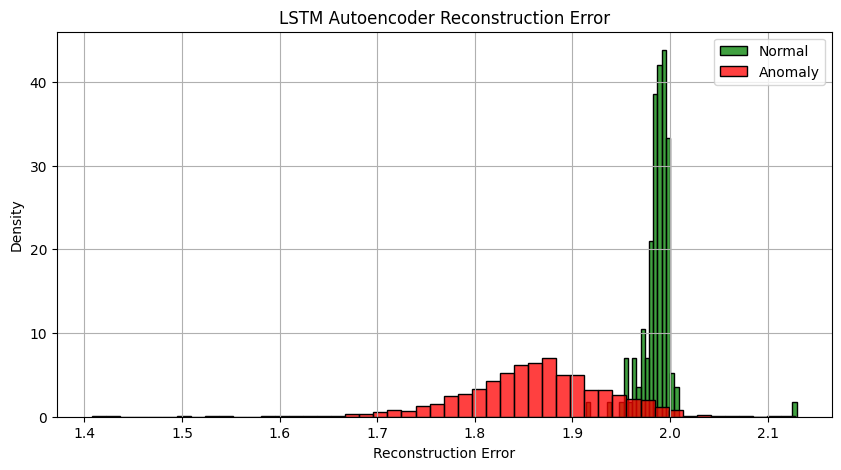

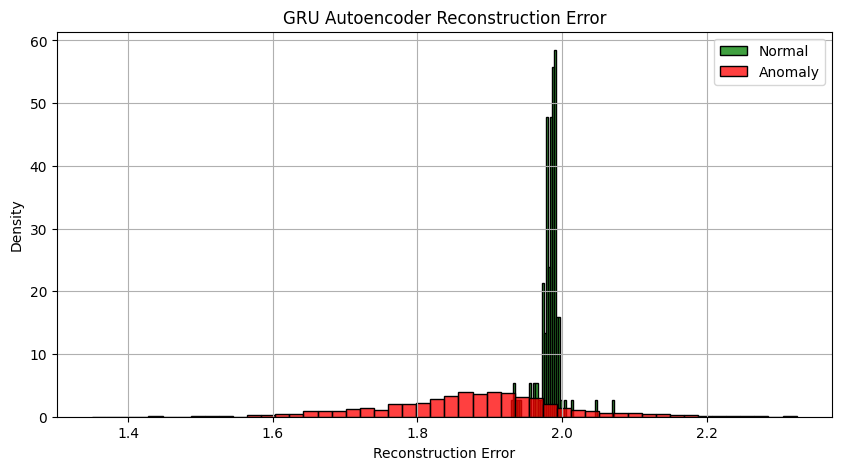

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_errors(normal_errors, anomaly_errors, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(normal_errors, bins=50, color='green', label='Normal', stat='density')
    sns.histplot(anomaly_errors, bins=50, color='red', label='Anomaly', stat='density')
    plt.title(title)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for LSTM
plot_errors(lstm_errors_normal, lstm_errors_anomaly, 'LSTM Autoencoder Reconstruction Error')

# Plot for GRU
plot_errors(gru_errors_normal, gru_errors_anomaly, 'GRU Autoencoder Reconstruction Error')


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_metrics(normal_errors, anomaly_errors, threshold):
    y_true = np.concatenate([np.zeros_like(normal_errors), np.ones_like(anomaly_errors)])
    y_pred = np.concatenate([normal_errors < threshold, anomaly_errors >= threshold])
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

threshold_lstm = np.percentile(lstm_errors_normal, 95)
precision, recall, f1 = get_metrics(lstm_errors_normal, lstm_errors_anomaly, threshold_lstm)
print(f"LSTM Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


LSTM Precision: 0.24, Recall: 0.02, F1: 0.03


In [50]:
print ("threshold_lstm = ",threshold_lstm)


threshold_lstm =  1.9996107637882232


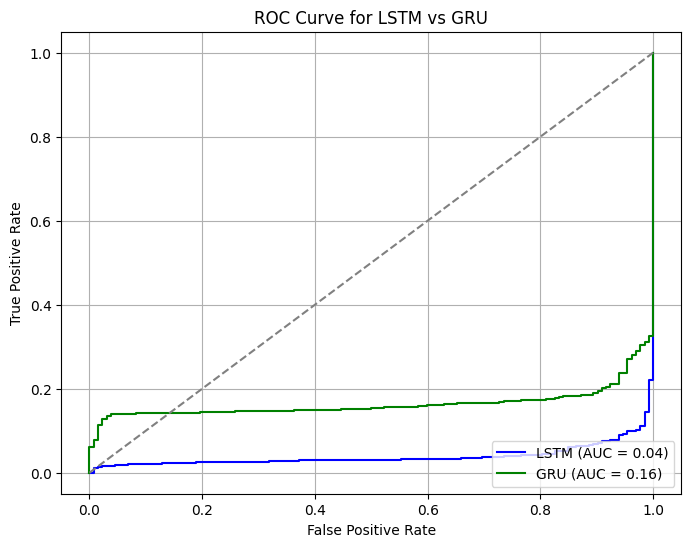

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Combine normal and anomaly errors
lstm_errors = np.concatenate([lstm_errors_normal, lstm_errors_anomaly])
gru_errors = np.concatenate([gru_errors_normal, gru_errors_anomaly])

# Create labels: 0 = normal, 1 = anomaly
labels = np.concatenate([np.zeros(len(lstm_errors_normal)), np.ones(len(lstm_errors_anomaly))])

# Compute ROC for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(labels, lstm_errors)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute ROC for GRU
fpr_gru, tpr_gru, _ = roc_curve(labels, gru_errors)
roc_auc_gru = auc(fpr_gru, tpr_gru)

# Plot both ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_gru, tpr_gru, color='green', label=f'GRU (AUC = {roc_auc_gru:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and legend
plt.title('ROC Curve for LSTM vs GRU')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


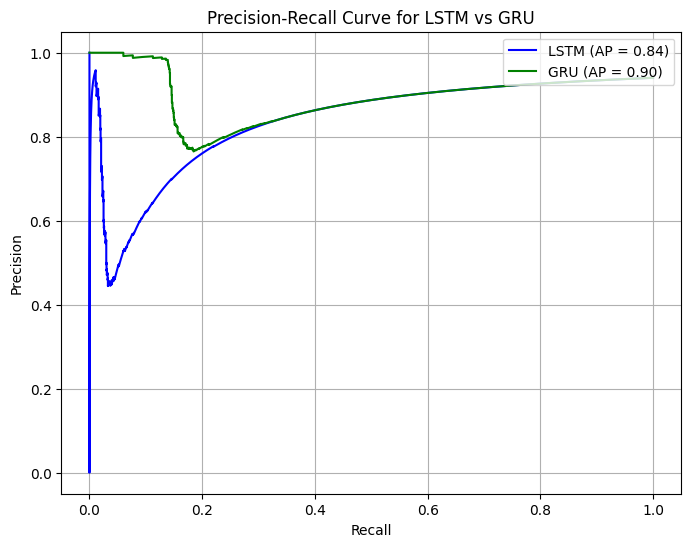

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute precision-recall for LSTM
precision_lstm, recall_lstm, _ = precision_recall_curve(labels, lstm_errors)
avg_precision_lstm = average_precision_score(labels, lstm_errors)

# Compute precision-recall for GRU
precision_gru, recall_gru, _ = precision_recall_curve(labels, gru_errors)
avg_precision_gru = average_precision_score(labels, gru_errors)

# Plot the PR curves
plt.figure(figsize=(8,6))
plt.plot(recall_lstm, precision_lstm, color='blue', label=f'LSTM (AP = {avg_precision_lstm:.2f})')
plt.plot(recall_gru, precision_gru, color='green', label=f'GRU (AP = {avg_precision_gru:.2f})')

# Labels and legend
plt.title('Precision-Recall Curve for LSTM vs GRU')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [36]:
# Threshold as 95th percentile of LSTM validation errors
lstm_val_errors = evaluate_model(model_lstm, val_dataset)
lstm_threshold = np.percentile(lstm_val_errors, 95)

# Same for GRU
gru_val_errors = evaluate_model(model_gru, val_dataset)
gru_threshold = np.percentile(gru_val_errors, 95)


In [37]:
# Predict with LSTM
lstm_predictions = (lstm_errors_anomaly > lstm_threshold).astype(int)  # 1 = anomaly, 0 = normal

# Predict with GRU
gru_predictions = (gru_errors_anomaly > gru_threshold).astype(int)


In [52]:
print ("gru_threshold = ", gru_threshold)
print ("lstm_threshold = ",lstm_threshold)

precision, recall, f1 = get_metrics(lstm_errors_normal, lstm_errors_anomaly, lstm_threshold)
print(f"LSTM Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


precision, recall, f1 = get_metrics(gru_errors_normal, gru_errors_anomaly, gru_threshold)
print(f"GRU Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


gru_threshold =  1.995337575674057
lstm_threshold =  2.0007448196411133
LSTM Precision: 0.22, Recall: 0.02, F1: 0.03
GRU Precision: 0.71, Recall: 0.14, F1: 0.23


In [39]:
print(lstm_predictions)

[0 0 0 ... 0 0 0]


In [40]:
print(gru_predictions)

[0 0 0 ... 0 0 0]


In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# True labels: 0 = normal, 1 = anomaly
true_labels = np.concatenate([
    np.zeros(len(test_normal_dataset)),
    np.ones(len(test_anomaly_dataset))
])

# Predicted labels
lstm_pred_all = np.concatenate([
    (lstm_errors_normal > lstm_threshold).astype(int),
    (lstm_errors_anomaly > lstm_threshold).astype(int)
])
gru_pred_all = np.concatenate([
    (gru_errors_normal > gru_threshold).astype(int),
    (gru_errors_anomaly > gru_threshold).astype(int)
])

# Evaluation
print("LSTM Classification Report:")
print(classification_report(true_labels, lstm_pred_all))
print("GRU Classification Report:")
print(classification_report(true_labels, gru_pred_all))


LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.06      0.95      0.11       132
         1.0       0.86      0.02      0.03      2079

    accuracy                           0.07      2211
   macro avg       0.46      0.49      0.07      2211
weighted avg       0.81      0.07      0.04      2211

GRU Classification Report:
              precision    recall  f1-score   support

         0.0       0.06      0.92      0.12       132
         1.0       0.97      0.14      0.25      2079

    accuracy                           0.19      2211
   macro avg       0.52      0.53      0.18      2211
weighted avg       0.91      0.19      0.24      2211



In [42]:
# Step 1: Concatenate reconstruction errors
lstm_errors_all = np.concatenate([lstm_errors_normal, lstm_errors_anomaly])
gru_errors_all = np.concatenate([gru_errors_normal, gru_errors_anomaly])

# Step 2: Use precision-recall curve
from sklearn.metrics import precision_recall_curve
import numpy as np

# Compute precision-recall for LSTM
precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(true_labels, lstm_errors_all)

# Compute F1 scores
f1_lstm = 2 * precision_lstm * recall_lstm / (precision_lstm + recall_lstm + 1e-6)

# Best threshold
best_idx_lstm = np.argmax(f1_lstm)
best_threshold_lstm = thresholds_lstm[best_idx_lstm]

print(f"Best LSTM threshold by F1: {best_threshold_lstm:.4f}")


Best LSTM threshold by F1: 1.4079


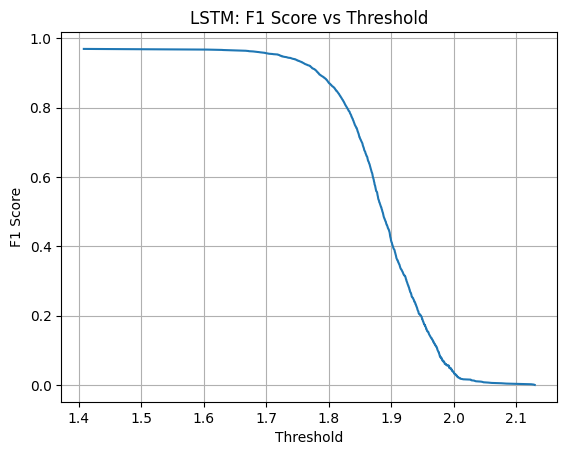

In [43]:
import matplotlib.pyplot as plt

plt.plot(thresholds_lstm, f1_lstm[:-1])  # Last F1 has no threshold
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("LSTM: F1 Score vs Threshold")
plt.grid()
plt.show()


In [44]:
# Use best threshold
lstm_pred_all = (lstm_errors_all > best_threshold_lstm).astype(int)

# Re-evaluate
from sklearn.metrics import classification_report
print("Updated LSTM Classification Report:")
print(classification_report(true_labels, lstm_pred_all))


Updated LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       132
         1.0       0.94      1.00      0.97      2079

    accuracy                           0.94      2211
   macro avg       0.47      0.50      0.48      2211
weighted avg       0.88      0.94      0.91      2211



In [45]:
gru_errors_all = np.concatenate([gru_errors_normal, gru_errors_anomaly])
from sklearn.metrics import precision_recall_curve
import numpy as np

# Compute precision, recall, thresholds
precision_gru, recall_gru, thresholds_gru = precision_recall_curve(true_labels, gru_errors_all)

# Compute F1 score
f1_gru = 2 * precision_gru * recall_gru / (precision_gru + recall_gru + 1e-6)

# Find best threshold
best_idx_gru = np.argmax(f1_gru)
best_threshold_gru = thresholds_gru[best_idx_gru]

print(f"Best GRU threshold by F1: {best_threshold_gru:.4f}")


Best GRU threshold by F1: 1.3500


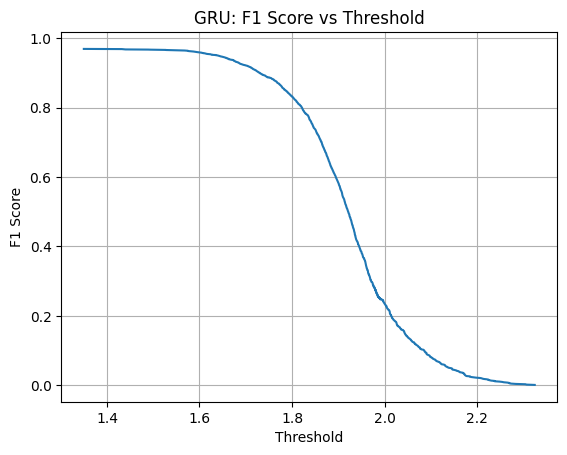

In [46]:
import matplotlib.pyplot as plt

plt.plot(thresholds_gru, f1_gru[:-1])  # Skip last F1 which has no corresponding threshold
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("GRU: F1 Score vs Threshold")
plt.grid(True)
plt.show()
    

In [47]:
# Predict using the best threshold
gru_pred_all = (gru_errors_all > best_threshold_gru).astype(int)

# Evaluate
from sklearn.metrics import classification_report

print("Updated GRU Classification Report:")
print(classification_report(true_labels, gru_pred_all))


Updated GRU Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       132
         1.0       0.94      1.00      0.97      2079

    accuracy                           0.94      2211
   macro avg       0.47      0.50      0.48      2211
weighted avg       0.88      0.94      0.91      2211

